<a href="https://colab.research.google.com/github/nathanaeliw/Python-for-Data-Science-and-AI-Group-17-/blob/main/1spotify_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Research Question: Is there a significant difference in the popularity of the genre pop within the period 2010s to 2020s pop songs?

A one-tailed independent t-test was conducted to compare the mean popularity scores of pop songs between the 2010s and 2020s.

H₀ (Null Hypothesis): There is no significant difference in the average Spotify popularity scores of pop songs released in the 2010s and those released in the 2020s.

H₁ (Alternative Hypothesis): Pop songs released in the 2020s have significantly higher average Spotify popularity scores than those released in the 2010s.

In [1]:
import requests
import base64
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
from scipy import stats

client_id = "026e85b21ea044a28bc0c95288c3a676"
client_secret = "6f77079dcfd74e6f9945989fd4e91954"

auth_str = f"{client_id}:{client_secret}"
b64_auth = base64.b64encode(auth_str.encode()).decode()

token_url = "https://accounts.spotify.com/api/token"
response = requests.post(token_url, {
    "grant_type": "client_credentials"
}, headers={
    "Authorization": f"Basic {b64_auth}"
})
access_token = response.json()['access_token']

headers = {"Authorization": f"Bearer {access_token}"}

In [2]:
def get_popularity(track):
    return track["popularity"]

def get_pop_songs(decade_query):
    all_tracks = []
    for offset in range(0, 1000, 50):  # get up to 1000 results
        params = {
            "q": decade_query,
            "type": "track",
            "limit": 50,
            "offset": offset
        }
        r = requests.get("https://api.spotify.com/v1/search", headers=headers, params=params)
        data = r.json()
        if not data.get("tracks"):
            break
        all_tracks.extend(data["tracks"]["items"])

    all_tracks.sort(key=get_popularity, reverse=True)

    return all_tracks[:350]


pop_2010s = get_pop_songs("genre:pop year:2010-2019")
pop_2020s = get_pop_songs("genre:pop year:2020-2025")

min_len = min(len(pop_2010s), len(pop_2020s))
pop_2010s = pop_2010s[:min_len]
pop_2020s = pop_2020s[:min_len]

In [3]:
def create_dataframe(tracks, decade):
    return pd.DataFrame({
        "Track": [t["name"] for t in tracks],
        "Artist": [t["artists"][0]["name"] if t["artists"] else "Unknown Artist" for t in tracks],
        "Popularity": [t["popularity"] for t in tracks],
        "Decade": decade
    })

df_2010s = create_dataframe(pop_2010s, "2010s")
df_2020s = create_dataframe(pop_2020s, "2020s")
df = pd.concat([df_2010s, df_2020s], ignore_index=True)
print("\n")
df.info()
df.isnull().sum()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Track       700 non-null    object
 1   Artist      700 non-null    object
 2   Popularity  700 non-null    int64 
 3   Decade      700 non-null    object
dtypes: int64(1), object(3)
memory usage: 22.0+ KB


,0
Track,0
Artist,0
Popularity,0
Decade,0


In [4]:
df_2010s = df_2010s.drop_duplicates(subset=["Track", "Artist"])
df_2020s = df_2020s.drop_duplicates(subset=["Track", "Artist"])

In [5]:
t_stat, p_value = stats.ttest_ind(df_2020s["Popularity"], df_2010s["Popularity"], equal_var=False)
alpha = 0.05

print("\nHypothesis Test Result")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value/2:.100f}  (one-tailed test)")

if (t_stat > 0) and (p_value/2 < alpha):
    print("Reject H₀ -> 2020s pop songs are significantly more popular.")
else:
    print("Fail to reject H₀ → No significant difference in popularity.")
print("Conclusion: There is a strong evidence that 2020s pop songs are significantly more popular than 2010s pop songs.")


Hypothesis Test Result
T-statistic: 14.2913
P-value: 0.0000000000000000000000000000000000000001526765026115368368090331799099025462265947873965082294065786  (one-tailed test)
Reject H₀ -> 2020s pop songs are significantly more popular.
Conclusion: There is a strong evidence that 2020s pop songs are significantly more popular than 2010s pop songs.


Average popularity of Pop songs (2010s): 75.30
Average popularity of Pop songs (2020s): 81.06


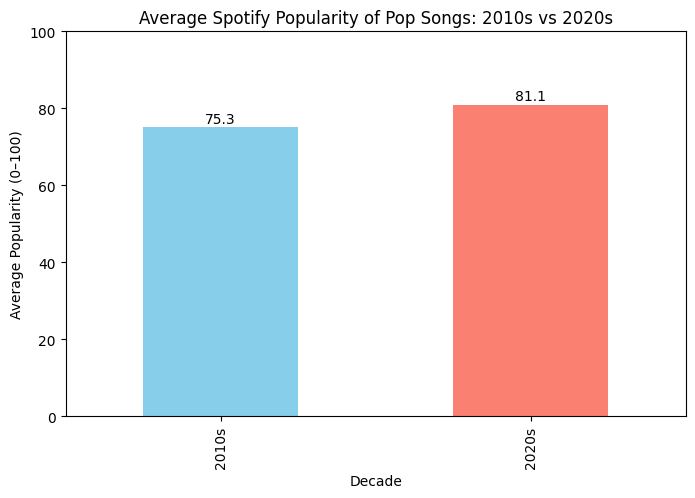

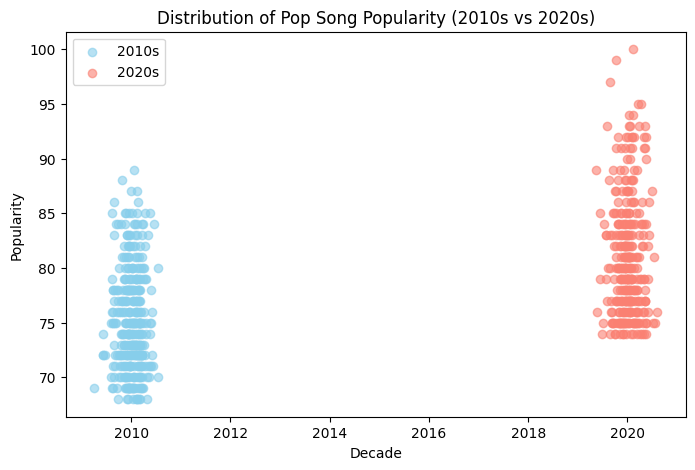

In [6]:
avg_2010s = df_2010s["Popularity"].mean()
avg_2020s = df_2020s["Popularity"].mean()

print(f"Average popularity of Pop songs (2010s): {avg_2010s:.2f}")
print(f"Average popularity of Pop songs (2020s): {avg_2020s:.2f}")
plt.figure(figsize=(8,5))
df.groupby("Decade")["Popularity"].mean().plot(kind="bar", color=["skyblue", "salmon"])
plt.title("Average Spotify Popularity of Pop Songs: 2010s vs 2020s")
plt.ylabel("Average Popularity (0–100)")
plt.ylim(0, 100)
for i, v in enumerate([avg_2010s, avg_2020s]):
    plt.text(i, v + 1, f"{v:.1f}", ha='center')
plt.show()

plt.figure(figsize=(8,5))
plt.scatter(np.random.normal(2010, 0.2, len(df_2010s)), df_2010s["Popularity"], alpha=0.6, label="2010s", color="skyblue")
plt.scatter(np.random.normal(2020, 0.2, len(df_2020s)), df_2020s["Popularity"], alpha=0.6, label="2020s", color="salmon")
plt.title("Distribution of Pop Song Popularity (2010s vs 2020s)")
plt.xlabel("Decade")
plt.ylabel("Popularity")
plt.legend()
plt.show()

In [7]:
def show_tracks(tracks, label):
    print(f"\nTop {len(tracks)} Pop Songs ({label})")
    for i, t in enumerate(tracks, start=1):
        name = t['name']
        artist = t['artists'][0]['name'] if t['artists'] else "Unknown Artist"
        popularity = t['popularity'] #number of popularity
        print(f"{i:2d}. {name} – {artist} (Popularity: {popularity})")

show_tracks(pop_2010s, "2010s")
show_tracks(pop_2020s, "2020s")



Top 350 Pop Songs (2010s)
 1. Apocalypse – Cigarettes After Sex (Popularity: 89)
 2. Locked out of Heaven – Bruno Mars (Popularity: 88)
 3. Someone You Loved – Lewis Capaldi (Popularity: 87)
 4. Photograph – Ed Sheeran (Popularity: 87)
 5. There's Nothing Holdin' Me Back – Shawn Mendes (Popularity: 86)
 6. Headlines – Drake (Popularity: 86)
 7. One Last Time – Ariana Grande (Popularity: 85)
 8. All of Me – John Legend (Popularity: 85)
 9. I'm Not The Only One – Sam Smith (Popularity: 85)
10. Say You Won't Let Go – James Arthur (Popularity: 85)
11. Love Me – Lil Wayne (Popularity: 85)
12. Sign of the Times – Harry Styles (Popularity: 85)
13. Sunsetz – Cigarettes After Sex (Popularity: 85)
14. Only Girl (In The World) – Rihanna (Popularity: 85)
15. Always Remember Us This Way – Lady Gaga (Popularity: 84)
16. Thinking out Loud – Ed Sheeran (Popularity: 84)
17. a thousand years – Christina Perri (Popularity: 84)
18. Uptown Funk (feat. Bruno Mars) – Mark Ronson (Popularity: 84)
19. TiK ToK